# Car Price Prediction

In [943]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [944]:
df = pd.read_csv("./car_price_dataset.csv")
# Note - Mileage => How many km has the car travelled

In [945]:
df.isnull().sum().sum()

0

In [946]:
df.head(5)

,Brand,Model,Year,Engine_Size,Fuel_Type,Transmission,Mileage,Doors,Owner_Count,Price
0,Kia,Rio,2020,4.2,Diesel,Manual,289944,3,5,8501
1,Chevrolet,Malibu,2012,2.0,Hybrid,Automatic,5356,2,3,12092
2,Mercedes,GLA,2020,4.2,Diesel,Automatic,231440,4,2,11171
3,Audi,Q5,2023,2.0,Electric,Manual,160971,2,1,11780
4,Volkswagen,Golf,2003,2.6,Hybrid,Semi-Automatic,286618,3,3,2867


In [947]:
# All data types are correct
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Brand         10000 non-null  object 
 1   Model         10000 non-null  object 
 2   Year          10000 non-null  int64  
 3   Engine_Size   10000 non-null  float64
 4   Fuel_Type     10000 non-null  object 
 5   Transmission  10000 non-null  object 
 6   Mileage       10000 non-null  int64  
 7   Doors         10000 non-null  int64  
 8   Owner_Count   10000 non-null  int64  
 9   Price         10000 non-null  int64  
dtypes: float64(1), int64(5), object(4)
memory usage: 781.4+ KB


In [948]:
# df["Year"] = df["Year"].values
# df["Year"] = df["Year"].to_numpy() - 2000

In [949]:
df["Year"]

0       2020
1       2012
2       2020
3       2023
4       2003
        ... 
9995    2004
9996    2002
9997    2010
9998    2002
9999    2001
Name: Year, Length: 10000, dtype: int64

In [950]:
y = df["Price"]
X = df.drop(["Price"], axis=1)

X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.4)
print("Training data", X_train.shape, y_train.shape)

X_cv, X_test, y_cv, y_test = train_test_split(X_, y_, test_size=0.5)
print("Cross Validation: ", X_cv.shape, y_cv.shape, "\nTest Data: ", X_test.shape, y_test.shape)

Training data (6000, 9) (6000,)
Cross Validation:  (2000, 9) (2000,) 
Test Data:  (2000, 9) (2000,)


In [951]:
label_encoding_cols = ["Model", "Fuel_Type", "Transmission", "Brand"] # Label encoding for XGBoost

In [952]:
encoders: dict[str, 'LabelEncoder'] = {}

for item in label_encoding_cols:
    encoder = LabelEncoder()
    series = X_train[item]
    encoder.fit(series)

    X_train[item] = encoder.transform(X_train[item])
    X_cv[item] = encoder.transform(X_cv[item])
    X_test[item] = encoder.transform(X_test[item])

    encoders[item] = encoder

X_train

,Brand,Model,Year,Engine_Size,Fuel_Type,Transmission,Mileage,Doors,Owner_Count
9037,3,13,2000,1.6,3,1,13049,2,5
9499,0,3,2000,1.9,0,0,179009,5,2
1975,2,18,2004,3.2,3,0,31309,3,2
3024,7,10,2019,3.7,0,0,143171,4,2
8798,5,25,2020,2.7,1,1,11279,4,2
...,...,...,...,...,...,...,...,...,...
7708,6,26,2006,3.5,2,1,80378,3,2
4468,9,17,2006,2.3,3,1,55654,2,5
4940,6,24,2022,3.2,1,0,207165,2,4
8115,8,23,2018,2.8,2,2,134787,4,1


In [953]:
# for item in label_encoding_cols:
#     encoder = encoders[item]
#     X_train[item] = encoder.inverse_transform(X_train[item])

# X_train

In [954]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()

In [955]:
scalar.fit(X_train["Mileage"].values.reshape(-1, 1))

X_train["Mileage"] = scalar.transform(X_train["Mileage"].values.reshape(-1, 1))
X_cv["Mileage"] = scalar.transform(X_cv["Mileage"].values.reshape(-1, 1))
X_test["Mileage"] = scalar.transform(X_test["Mileage"].values.reshape(-1, 1))

In [956]:
print(f"Min value: {X_train["Mileage"].min():0.2f}, Max Value: {X_train["Mileage"].max():0.2f}")
print(f"Mean: {X_train["Mileage"].mean():0.2f}")

Min value: -1.75, Max Value: 1.74
Mean: 0.00


In [957]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, accuracy_score

In [958]:
d_train = xgb.DMatrix(X_train.values, label=y_train.values) # Converting to DMatrix for faster calculation
d_cv = xgb.DMatrix(X_cv.values, label=y_cv.values) # Converting to DMatrix for faster calculation
d_test = xgb.DMatrix(X_test.values, label=y_test.values) # Converting to DMatrix for faster calculation


### Training

In [959]:
params = {
    "objective": "reg:squarederror",  # Regression objective
    "eval_metric": "rmse",
    "learning_rate": 0.06,
    "max_depth": 2,
    "alpha": 3,
    "lambda": 4
}

In [973]:
evals_result = {}

model = xgb.train(
    params=params, 
    dtrain=d_train, 
    num_boost_round=2500, 
    evals=[(d_train, "train"), (d_test, "test")], 
    evals_result=evals_result,  # ✅ Store loss values
    early_stopping_rounds=100,
)

[0]	train-rmse:2964.88028	test-rmse:3098.81025
[1]	train-rmse:2872.91216	test-rmse:3004.88609
[2]	train-rmse:2788.69473	test-rmse:2918.55659
[3]	train-rmse:2708.50519	test-rmse:2835.36447
[4]	train-rmse:2635.71080	test-rmse:2761.13911
[5]	train-rmse:2567.48163	test-rmse:2690.94409
[6]	train-rmse:2503.03220	test-rmse:2623.52629
[7]	train-rmse:2443.76770	test-rmse:2560.84210
[8]	train-rmse:2388.13274	test-rmse:2502.41045
[9]	train-rmse:2335.52396	test-rmse:2447.64015
[10]	train-rmse:2285.80212	test-rmse:2394.69285
[11]	train-rmse:2238.24402	test-rmse:2344.57640
[12]	train-rmse:2192.59979	test-rmse:2297.73268
[13]	train-rmse:2149.60369	test-rmse:2252.18223
[14]	train-rmse:2108.02584	test-rmse:2209.10053
[15]	train-rmse:2069.42083	test-rmse:2168.53295
[16]	train-rmse:2031.85629	test-rmse:2129.28175
[17]	train-rmse:1996.06896	test-rmse:2090.72347
[18]	train-rmse:1961.47984	test-rmse:2052.68300
[19]	train-rmse:1928.46039	test-rmse:2017.51837
[20]	train-rmse:1896.56433	test-rmse:1985.71417
[2

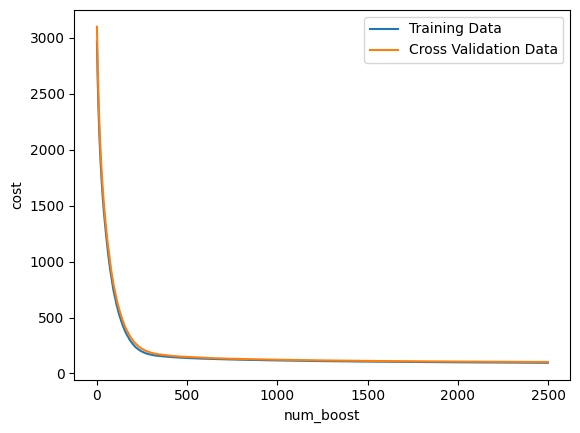

In [961]:
plt.plot(evals_result["train"]["rmse"])
plt.plot(evals_result["test"]["rmse"])
plt.legend(["Training Data", "Cross Validation Data"])
plt.xlabel("num_boost")
plt.ylabel("cost")
plt.show()

In [975]:
pred = model.predict(d_test)
print(mean_squared_error(y_test, pred))

10584.763671875


In [963]:
model.get_score(importance_type="weight")

{'f0': 91.0,
 'f1': 93.0,
 'f2': 1937.0,
 'f3': 1543.0,
 'f4': 718.0,
 'f5': 207.0,
 'f6': 2820.0,
 'f7': 48.0,
 'f8': 43.0}

In [964]:
diff = list(zip(y_test, pred))

In [965]:
# y_train[lambda x: x < 5000]

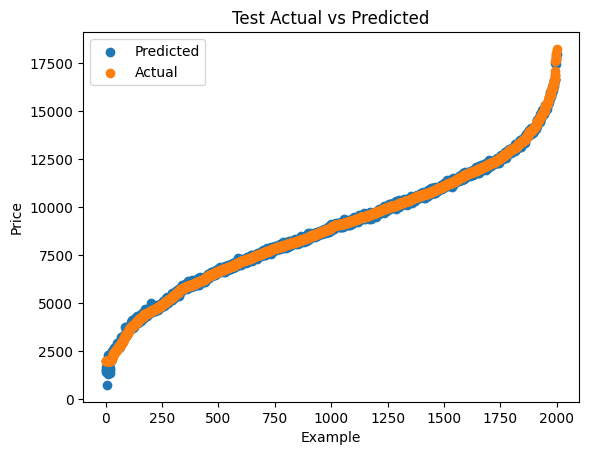

73.41465686035156

In [966]:
plot = np.array(list(sorted(diff, key=lambda x: x[0])))

plt.scatter(np.arange(y_test.shape[0]), plot[:, 1])
plt.scatter(np.arange(y_test.shape[0]), plot[:, 0])
plt.xlabel("Example")
plt.ylabel("Price")
plt.legend(["Predicted", "Actual"])
plt.title("Test Actual vs Predicted")
plt.show()

MAE = np.mean(np.abs(y_test - pred))
MAE

### K-FOLD Analysis

In [967]:
from sklearn.model_selection import KFold
import xgboost as xgb
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scores = []
mae_scores = []

for train_index, val_index in kf.split(X_train):
    X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

    dtrain = xgb.DMatrix(X_tr, label=y_tr)
    dval = xgb.DMatrix(X_val, label=y_val)

    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=2500,
        evals=[(dtrain, "train"), (dval, "val")],
        early_stopping_rounds=100,
        verbose_eval=False
    )

    preds = model.predict(dval)
    rmse = np.sqrt(np.mean((preds - y_val) ** 2))
    mae = np.mean(np.abs(preds - y_val))

    rmse_scores.append(rmse)
    mae_scores.append(mae)

print(f"Avg RMSE: {np.mean(rmse_scores):.4f}")
print(f"Avg MAE: {np.mean(mae_scores):.4f}")


Avg RMSE: 121.3479
Avg MAE: 81.8367


In [968]:
import pickle as pkl

for item in label_encoding_cols:
    with open(f"{item}.pkl", "wb") as file:
        pkl.dump(encoders[item], file)

In [969]:
with open("Mileage_Scalar.pkl", "wb") as file:
    pkl.dump(scalar, file)

In [976]:
with open("XGBModel.pkl", "wb") as file:
    pkl.dump(model, file)